In [78]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from typing import Tuple, List

In [80]:
class TimpaniData:
    def __init__(self, a: float, c_trans: float, alpha: float, b: float, b_3: float):
        self.a = a # Radius of the membrane (m)
        self.c_trans = c_trans # Speed of transversal waves. (m.s-1)
        self.alpha = alpha # (paramètre d'élasticité)
        self.b = b # (paramètre de viscosité)
        self.b_3 = b_3 # (coefficient relié à la force due au rayonnement de la membrane)

        self.w_0 = 0 # value of w outside of the circle.

class ImpactData:
    def __init__(self,p: Tuple[float, float], t_0: float, m: float, f_0: float):
        """
            p is normalised in [-0.5, 0.5]
        """
        self.m = m
        self.p = p
        self.t_0 = t_0
        self.f_0 = f_0

"""[summary]
Implements « Synthèse sonore de sons de tiimbale, A. Ramdane, 1990
source: http://www.edpsciences.org/10.1051/jphyscol:19902201
Differences in notation :
- w is used as the name for the transversal displacement of the membrane.
- n is used as the number of discrete time points (and not N).
- The time iterator's name is k (and not n).
"""
class TimpaniSolver:
    def __init__(self, data: TimpaniData, impData: ImpactData, dt: float, do_cache: bool):
        """[summary]
        Args:
            d (TimpaniData): [description]
            dt (float): [description]
            n (int): [description]
        """
        self.data = data
        self.impactData = impData

        self.dt = dt
        # dx and dy are set from dt, so that we have r_1**2 + r_2**2 = 1
        self.dx = self.dy = 2 *(self.dt * self.data.c_trans) ** 2
        self.h = self.dx # ? not sure about what that's supposed to be, or the value.

        self.n = int(np.ceil(self.data.a / self.dx))

        self.r_1 = self.data.c_trans * self.dt / self.dx
        self.r_2 = self.data.c_trans * self.dt / self.dy

        # cache of all w(i, j, k) computed for this data
        self.do_cache = do_cache
        self.clear()

    def compute_w(self, x: float, y: float, t: float) -> float:
        """[summary]
        (x, y) are normalised by the radius and originate from the centre of the membrane.
        Args:
            x (float): [description]
            y (float): [description]
            t (float): [description]

        Returns:
            float: [description]
        """
        i = int(np.round(((x + 0.5) * a) / self.dx))
        j = int(np.round(((y + 0.5) * a) / self.dy))
        k = int(np.round(t / self.dt))
        val = self.__compute_w(i, j, k)
        return self.w_cache[i, j, :]

    def clear(self) -> None:
        if self.do_cache:
            self.has_w = np.zeros((self.n, self.n, 1), dtype=bool)
            self.w_cache = np.zeros((self.n, self.n, 1), dtype=np.float32)
            self.visited_ps = []
    
    def __compute_w(self, i: int, j: int, k: int) -> float:
        """[summary]

        Args:
            i ([type]): [description]
            j ([type]): [description]
            k ([type]): [description]
        """
        if k <= 0 or (i < 0 or i >= self.n) or (j < 0 or j >= self.n):
            # At $t_0$, the displacement is null everywhere on the membrane.
            return self.data.w_0
        # Check whether the value has already been computed.
        if self.do_cache:
            if k > self.has_w.shape[2]:
                # extend cache
                self.has_w = np.append(self.has_w, np.zeros((self.has_w.shape[0], self.has_w.shape[1], k + 1 - self.has_w.shape[2])), axis=2)
                self.w_cache = np.append(self.w_cache, np.zeros((self.w_cache.shape[0], self.w_cache.shape[1], k + 1 - self.w_cache.shape[2])), axis=2)
            if self.has_w[i, j, k]:
                return self.w_cache[i, j, k]
        region = self.__get_point_region((i, j))
        w = None
        if region == 0:
            w = self.data.w_0
        elif region == 1:
            e_1 = lambda i, j, k: np.sqrt(self.n ** 2 - j ** 2)/self.h - i/self.h
            e_2 = lambda i, j, k: np.sqrt(self.n ** 2 - j ** 2)/self.h - i/self.h
            a = 2 * self.r_1**2 / (1 + e_1(i,j,k)* self.h)
            # pretty sure there is an error in the pdf of the article for this coefficient.
            # for now, I copied it as-is.
            b = - 2 * (self.r_1**2 * (self.h / e_1(i,j,k) + self.h / e_2(i, j, k)) - 1)
            c = 2 * self.r_1**2 / (1 + e_2(i,j,k) * self.h)
            d = -1
            #
            w = a * self.__compute_w(i-1, j, k-1) + \
                b * self.__compute_w(i, j, k-1) + \
                c * self.__compute_w(i, j-1, k-1) + \
                d * self.__compute_w(i, j, k-2)
        else:
            print("NOOOOOO")
            # Re-writing the equation (5) from the article to extract the most up-to-date w (largest k)
            avg_z = 0
            d_x_2_w = lambda i, j, k: self.__compute_w(i+1, j, k) - 2 * self.__compute_w(i, j, k) + self.__compute_w(i-1, j, k)
            d_y_2_w = lambda i, j, k: self.__compute_w(i, j+1, k) - 2 * self.__compute_w(i, j, k) + self.__compute_w(i, j-1, k)
            d_t_w = lambda i, j, k: self.__compute_w(i, j, k+1) - self.__compute_w(i, j, k)
            d_t_2_w = lambda i, j, k: d_t_w(d_t_w(i, j, k))
            res_w = lambda i, j, k: 2 * self.__compute_w(i, j, k+1) + 2 * self.__compute_w(i, j, k-1) - self.__compute_w(i, j, k-2)
            k_p = k-2 # retard par rapport à la formule de l'article
            w = self.dt**3/self.b_3 * \
                (r_1 ** 2 * d_x_2_z(i, j, k_p) + r_2 ** 2 * d_y_2_z(i, j, k_p) \
                - b/self.dt * d_t_w(i, j, k_p) + self.alpha * avg_z - d_t_2_w(i, j, k_p)) + \
                res_w(i, j, k_p)
            
        p_grid = np.int32(np.round((np.array(self.impactData.p) + 0.5) * self.n))
        p_ij = np.array([i, j], dtype=np.int32)
        t_k = np.int32(np.round(self.impactData.t_0 / self.dt))
        # Implement a simple impulsion at $t_0$ on (x, y)
        if k == t_k and p_grid == p_ij:
            w += self.impactData.f_0
            print(w)
        if self.do_cache:
            self.w_cache[i, j, k] = w
            self.has_w[i, j, k] = True
            if (i, j) not in self.visited_ps:
                self.visited_ps.append((i, j))
        return w


    def __get_point_region(self, p: Tuple[int, int]) -> int:
        """[summary]
        Get the region of the (i, j) point,
        can be 0: circular rim or outside
            1: neighbourhood of the circular rim on the inside
            2: inside the circle
        Args:
            n ([type]): [description]
            p (Tuple[int, int]): Point of indices (i, j) in the grid.
        """
        radius = self.n * 0.5
        norm = lin.norm(np.array(p, dtype=np.float64))
        diff = radius - norm
        if norm < radius:
            return 0
        elif norm >= radius - 1:
            return 1
        else:
            return 2 

In [85]:

a = 0.3
c_trans = 500 
alpha = 5 # (paramètre d'élasticité)
b = 0.3 # (paramètre de viscosité)
b_3 = 1 # (coefficient relié à la force due au rayonnement de la membrane)

data = TimpaniData(a, c_trans, alpha, b, b_3)

p = (0, 0)
t_0 = 0
m = 0.5
f_0 = 2
 
impactData = ImpactData(p, t_0, m, f_0)

In [86]:
f_e = 4410 # try to have f_e low
dt = 1/f_e
do_cache = True

solver = TimpaniSolver(data, impactData, dt, do_cache)

In [87]:
x = 0
y = 0
t = 0.5

w = solver.compute_w(x, y, t)

[(0, 6), (0, 5), (1, 6), (1, 5), (2, 6), (2, 5), (3, 6), (3, 5), (4, 6), (4, 5), (4, 4), (5, 6), (5, 5), (5, 4), (5, 3), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (5, 2), (6, 1), (5, 1), (6, 0), (5, 0)]


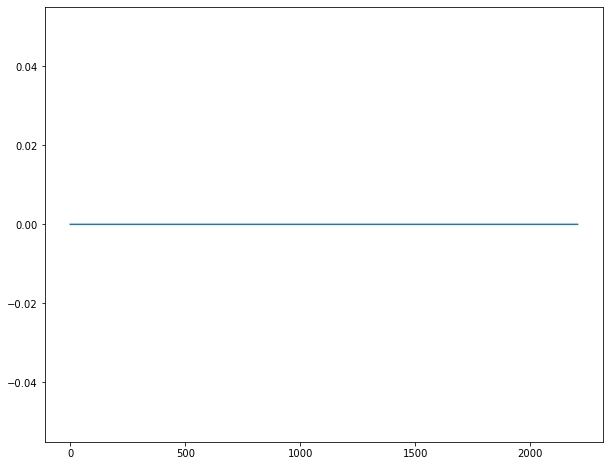

In [88]:
ps = solver.visited_ps
print(ps)

plt.figure(figsize=(10, 8))
plt.plot(w)